<a href="https://colab.research.google.com/github/mennah29/medical-ct-segmentation/blob/main/Copy_of_Untitled17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Download and extract your CT dataset
!gdown --id 1l6ViBkrONX5KAdziNfeB7G3AS98pb5WV
!unzip -q /content/CT_subset_big.zip -d /content/

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1l6ViBkrONX5KAdziNfeB7G3AS98pb5WV
From (redirected): https://drive.google.com/uc?id=1l6ViBkrONX5KAdziNfeB7G3AS98pb5WV&confirm=t&uuid=0e24e3c0-90e1-4c7c-9ff5-f744cde7add2
To: /content/CT_subset_big.zip
100% 452M/452M [00:03<00:00, 140MB/s]


In [ ]:
# Step 2: Install all necessary packages
!pip install -q monai nibabel plotly scikit-image trimesh torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 735.5/735.5 kB 52.0 MB/s eta 0:00:00


In [ ]:
# Step 3: Import all libraries
import os
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
from monai.networks.nets import UNet
from monai.losses import DiceLoss
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from skimage import measure
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.colors as pc
from plotly.subplots import make_subplots

In [ ]:
# Step 4: Explore dataset and find organs with data
def explore_dataset():
    data_dir = "/content"
    patients = [d for d in os.listdir(data_dir) if d.startswith('s') and len(d) == 5]
    print(f"Found {len(patients)} patients")

    # Check first patient
    first_patient = os.path.join(data_dir, patients[0])
    print(f"\nFirst patient: {patients[0]}")
    print("Contents:", os.listdir(first_patient))

    # Find organs with data
    organs_with_data = {}
    for patient in patients[:5]:  # Check first 5 patients
        seg_dir = os.path.join(data_dir, patient, "segmentations")
        if os.path.exists(seg_dir):
            for organ_file in os.listdir(seg_dir):
                if organ_file.endswith('.nii.gz'):
                    organ_name = organ_file.replace('.nii.gz', '')
                    organ_path = os.path.join(seg_dir, organ_file)

                    organ_data = nib.load(organ_path).get_fdata()
                    voxel_count = np.sum(organ_data > 0)

                    if voxel_count > 0:
                        if organ_name not in organs_with_data:
                            organs_with_data[organ_name] = []
                        organs_with_data[organ_name].append(patient)

    print(f"\n🎯 Found {len(organs_with_data)} organs with data:")
    for organ, patients_list in sorted(organs_with_data.items()):
        print(f"  - {organ}: {len(patients_list)} patients")

    return organs_with_data, patients

organs_with_data, all_patients = explore_dataset()

Found 21 patients

First patient: s0019
Contents: ['segmentations', 'ct.nii.gz']

🎯 Found 115 organs with data:
  - adrenal_gland_left: 2 patients
  - adrenal_gland_right: 2 patients
  - aorta: 3 patients
  - atrial_appendage_left: 2 patients
  - autochthon_left: 5 patients
  - autochthon_right: 5 patients
  - brachiocephalic_trunk: 2 patients
  - brachiocephalic_vein_left: 2 patients
  - brachiocephalic_vein_right: 2 patients
  - brain: 3 patients
  - clavicula_left: 3 patients
  - clavicula_right: 3 patients
  - colon: 2 patients
  - common_carotid_artery_left: 4 patients
  - common_carotid_artery_right: 4 patients
  - costal_cartilages: 3 patients
  - duodenum: 2 patients
  - esophagus: 5 patients
  - femur_left: 2 patients
  - femur_right: 2 patients
  - gallbladder: 2 patients
  - gluteus_maximus_left: 2 patients
  - gluteus_maximus_right: 2 patients
  - gluteus_medius_left: 2 patients
  - gluteus_medius_right: 2 patients
  - gluteus_minimus_left: 2 patients
  - gluteus_minimus_ri

In [ ]:
# Step 5: Create colorful 3D visualizer with vibrant colors
class ColorfulOrganVisualizer:
    def __init__(self):
        self.meshes = {}
        # Vibrant color scheme for different organ types
        self.colors = {
            # Bones - Warm colors
            'hip_right': 'rgba(255, 140, 0, 0.8)',      # Dark Orange
            'hip_left': 'rgba(255, 165, 0, 0.8)',       # Orange
            'femur_left': 'rgba(255, 69, 0, 0.8)',      # Red-Orange
            'femur_right': 'rgba(255, 99, 71, 0.8)',    # Tomato
            'sacrum': 'rgba(210, 105, 30, 0.8)',        # Chocolate
            'rib_right_12': 'rgba(205, 133, 63, 0.8)',  # Peru

            # Muscles - Purple/Blue tones
            'gluteus_maximus_left': 'rgba(138, 43, 226, 0.7)',   # Blue Violet
            'gluteus_maximus_right': 'rgba(147, 112, 219, 0.7)', # Medium Purple
            'gluteus_medius_left': 'rgba(123, 104, 238, 0.7)',   # Medium Slate Blue
            'gluteus_medius_right': 'rgba(106, 90, 205, 0.7)',   # Slate Blue
            'gluteus_minimus_left': 'rgba(72, 61, 139, 0.7)',    # Dark Slate Blue
            'gluteus_minimus_right': 'rgba(65, 105, 225, 0.7)',  # Royal Blue
            'iliopsoas_left': 'rgba(70, 130, 180, 0.7)',         # Steel Blue
            'iliopsoas_right': 'rgba(100, 149, 237, 0.7)',       # Cornflower Blue

            # Organs - Green tones
            'colon': 'rgba(34, 139, 34, 0.8)',          # Forest Green
            'urinary_bladder': 'rgba(50, 205, 50, 0.8)', # Lime Green
            'small_bowel': 'rgba(144, 238, 144, 0.8)',   # Light Green

            # Blood Vessels - Red tones
            'iliac_artery_left': 'rgba(220, 20, 60, 0.8)',    # Crimson
            'iliac_artery_right': 'rgba(255, 0, 0, 0.8)',     # Red
            'iliac_vena_left': 'rgba(199, 21, 133, 0.8)',     # Medium Violet Red
            'iliac_vena_right': 'rgba(219, 112, 147, 0.8)',   # Pale Violet Red
        }

        # Organ categories for grouping
        self.categories = {
            'bones': ['hip_right', 'hip_left', 'femur_left', 'femur_right', 'sacrum', 'rib_right_12'],
            'muscles': ['gluteus_maximus_left', 'gluteus_maximus_right', 'gluteus_medius_left',
                       'gluteus_medius_right', 'gluteus_minimus_left', 'gluteus_minimus_right',
                       'iliopsoas_left', 'iliopsoas_right'],
            'organs': ['colon', 'urinary_bladder', 'small_bowel'],
            'vessels': ['iliac_artery_left', 'iliac_artery_right', 'iliac_vena_left', 'iliac_vena_right']
        }

    def create_mesh(self, segmentation_data, organ_name):
        """Create 3D mesh from segmentation data"""
        try:
            verts, faces, _, _ = measure.marching_cubes(segmentation_data, level=0.5)
            self.meshes[organ_name] = (verts, faces)
            return True
        except Exception as e:
            print(f"Could not create mesh for {organ_name}: {e}")
            return False

    def create_interactive_plot(self, title="🎨 3D Organ Segmentation - Colorful Anatomy"):
        """Create interactive 3D visualization with colorful organs"""
        if not self.meshes:
            print("No meshes to visualize!")
            return None

        fig = go.Figure()

        # Add each organ mesh with its color
        for organ_name, (verts, faces) in self.meshes.items():
            x, y, z = verts.T
            i, j, k = faces.T

            color = self.colors.get(organ_name, 'rgba(150, 150, 150, 0.7)')

            fig.add_trace(go.Mesh3d(
                x=x, y=y, z=z, i=i, j=j, k=k,
                color=color,
                name=organ_name.replace('_', ' ').title(),
                opacity=0.8,
                visible=True,
                flatshading=True
            ))

        # Create category buttons
        buttons = []

        # Show All
        buttons.append(dict(
            label="🌈 Show All",
            method="update",
            args=[{"visible": [True] * len(self.meshes)}]
        ))

        # Hide All
        buttons.append(dict(
            label="👁️ Hide All",
            method="update",
            args=[{"visible": [False] * len(self.meshes)}]
        ))

        # Category buttons
        for category, organs in self.categories.items():
            visibility = []
            for organ_name in self.meshes.keys():
                visibility.append(organ_name in organs)
            buttons.append(dict(
                label=f"📁 {category.title()}",
                method="update",
                args=[{"visible": visibility}]
            ))

        # Individual organ buttons
        for i, organ_name in enumerate(self.meshes.keys()):
            visibility = [False] * len(self.meshes)
            visibility[i] = True
            buttons.append(dict(
                label=f"🎯 {organ_name.replace('_', ' ').title()}",
                method="update",
                args=[{"visible": visibility}]
            ))

        fig.update_layout(
            title=dict(
                text=f"<b>{title}</b><br>"
                     "<i>🌈 Color-coded anatomy • Click legend or use dropdown</i>",
                x=0.5,
                xanchor='center',
                font=dict(size=20, color='white')
            ),
            scene=dict(
                xaxis=dict(visible=False, showbackground=False),
                yaxis=dict(visible=False, showbackground=False),
                zaxis=dict(visible=False, showbackground=False),
                bgcolor='rgba(5, 5, 15, 1)',
                aspectmode='data'
            ),
            updatemenus=[dict(
                type="dropdown",
                direction="down",
                x=0.02,
                y=0.98,
                buttons=buttons,
                bgcolor='black',
                bordercolor='white',
                font=dict(color='white')
            )],
            width=1100,
            height=800,
            showlegend=True,
            legend=dict(
                x=1.02,
                y=0.5,
                bgcolor='rgba(0,0,0,0.8)',
                bordercolor='white',
                font=dict(color='white', size=12)
            ),
            paper_bgcolor='rgba(0,0,0,1)',
            plot_bgcolor='rgba(0,0,0,1)'
        )

        return fig

# Initialize visualizer
colorful_viz = ColorfulOrganVisualizer()

In [ ]:
# Step 6: Create MONAI-based segmentation model
class OrganSegmentationModel:
    def __init__(self, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        self.model = self._create_unet()
        self.model.to(device)
        print(f"✅ Model initialized on {device}")

    def _create_unet(self):
        """Create a 3D UNet model for organ segmentation"""
        return UNet(
            spatial_dims=3,
            in_channels=1,
            out_channels=1,  # Binary segmentation
            channels=(32, 64, 128, 256, 512),
            strides=(2, 2, 2, 2),
            num_res_units=2,
            norm='BATCH'
        )

    def train(self, train_loader, epochs=10):
        """Train the segmentation model"""
        criterion = DiceLoss(sigmoid=True)
        optimizer = optim.Adam(self.model.parameters(), lr=1e-4)

        print("🚀 Starting training...")
        self.model.train()

        for epoch in range(epochs):
            total_loss = 0
            for batch_idx, (ct_scans, masks) in enumerate(train_loader):
                ct_scans, masks = ct_scans.to(self.device), masks.to(self.device)

                optimizer.zero_grad()
                outputs = self.model(ct_scans)
                loss = criterion(outputs, masks)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            avg_loss = total_loss / len(train_loader)
            print(f'📈 Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

        print("✅ Training completed!")

# Initialize model
seg_model = OrganSegmentationModel()

✅ Model initialized on cuda


In [ ]:
# Step 7: Create dataset for training
class OrganSegmentationDataset(Dataset):
    def __init__(self, patient_ids, organ_name, target_shape=(128, 128, 128)):
        self.patient_ids = patient_ids
        self.organ_name = organ_name
        self.target_shape = target_shape
        self.samples = self._load_samples()

    def _load_samples(self):
        """Load CT scans and organ masks"""
        samples = []
        for patient_id in self.patient_ids:
            patient_path = f"/content/{patient_id}"

            ct_path = os.path.join(patient_path, "ct.nii.gz")
            organ_path = os.path.join(patient_path, "segmentations", f"{self.organ_name}.nii.gz")

            if os.path.exists(ct_path) and os.path.exists(organ_path):
                ct_img = nib.load(ct_path)
                organ_img = nib.load(organ_path)

                ct_data = ct_img.get_fdata()
                organ_data = organ_img.get_fdata()

                # Only use if organ has data
                if np.sum(organ_data > 0) > 100:  # At least 100 voxels
                    samples.append({
                        'ct': ct_data,
                        'mask': organ_data,
                        'patient': patient_id
                    })

        print(f"📊 Loaded {len(samples)} samples for {self.organ_name}")
        return samples

    def _resize_volume(self, volume):
        """Resize volume to target shape"""
        from scipy.ndimage import zoom
        factors = [self.target_shape[i] / volume.shape[i] for i in range(3)]
        return zoom(volume, factors, order=1)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        ct = self.samples[idx]['ct']
        mask = self.samples[idx]['mask']

        # Resize to fixed shape
        ct = self._resize_volume(ct)
        mask = self._resize_volume(mask)

        # Normalize CT scan
        ct = (ct - ct.min()) / (ct.max() - ct.min())

        # Convert to tensors and add channel dimension
        ct_tensor = torch.from_numpy(ct).float().unsqueeze(0)  # [1, D, H, W]
        mask_tensor = torch.from_numpy(mask).float().unsqueeze(0)  # [1, D, H, W]

        return ct_tensor, mask_tensor

In [ ]:
# Step 8: Train model on organs with data
if organs_with_data:
    # Pick an organ that has data in multiple patients
    available_organs = list(organs_with_data.keys())
    print(f"Available organs: {available_organs[:10]}...")  # Show first 10

    # Let's train on colon (usually good data)
    target_organ = 'colon' if 'colon' in available_organs else available_organs[0]
    print(f"\n🎯 Training model to segment: {target_organ}")

    # Use patients that have this organ
    train_patients = organs_with_data[target_organ][:3]  # Use first 3 patients

    # Create dataset and dataloader
    train_dataset = OrganSegmentationDataset(train_patients, target_organ)
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

    if len(train_dataset) > 0:
        # Train the model
        seg_model.train(train_loader, epochs=5)

        # Test on a different patient
        test_patient = [p for p in all_patients if p not in train_patients][0]
        print(f"\n🧪 Testing on patient: {test_patient}")

    else:
        print("❌ Not enough training data")
else:
    print("❌ No organs with data found")

Available organs: ['vertebrae_S1', 'rib_left_1', 'hip_right', 'kidney_left', 'rib_left_10', 'colon', 'heart', 'vertebrae_C7', 'kidney_right', 'rib_left_4']...

🎯 Training model to segment: colon
📊 Loaded 2 samples for colon
🚀 Starting training...
📈 Epoch [1/5], Loss: 0.9846
📈 Epoch [2/5], Loss: 0.9821
📈 Epoch [3/5], Loss: 0.9803
📈 Epoch [4/5], Loss: 0.9789
📈 Epoch [5/5], Loss: 0.9770
✅ Training completed!

🧪 Testing on patient: s0003


In [ ]:
# Step 9: Load organs and create colorful visualization
def load_organs_for_visualization(patient_id="s0000", max_organs=8):
    """Load multiple organs for visualization"""
    patient_path = f"/content/{patient_id}"
    seg_dir = os.path.join(patient_path, "segmentations")

    if not os.path.exists(seg_dir):
        print(f"❌ Segmentations not found for {patient_id}")
        return []

    print(f"🎨 Loading organs from {patient_id} for colorful visualization...")

    successful_organs = []
    organs_loaded = 0

    # Try to load organs from our color scheme
    for organ in colorful_viz.colors.keys():
        if organs_loaded >= max_organs:
            break

        organ_path = os.path.join(seg_dir, f"{organ}.nii.gz")
        if os.path.exists(organ_path):
            try:
                organ_img = nib.load(organ_path)
                organ_data = organ_img.get_fdata()

                voxel_count = np.sum(organ_data > 0)
                if voxel_count > 0:
                    if colorful_viz.create_mesh(organ_data, organ):
                        successful_organs.append(organ)
                        organs_loaded += 1
                        print(f"   ✅ {organ}: {voxel_count:,} voxels")
                    else:
                        print(f"   ❌ {organ}: Mesh failed")
                else:
                    print(f"   ❌ {organ}: No data")
            except Exception as e:
                print(f"   ❌ {organ}: Error - {e}")

    print(f"\n🎉 Loaded {len(successful_organs)} organs for visualization")
    return successful_organs

# Load organs from first patient
organs_loaded = load_organs_for_visualization("s0000")

# Create the colorful interactive plot
if organs_loaded:
    fig = colorful_viz.create_interactive_plot()
    fig.show()
    print("\n🎮 Interactive Controls:")
    print("   • Click legend items to show/hide organs")
    print("   • Use dropdown for categories (Bones, Muscles, etc.)")
    print("   • Drag to rotate, scroll to zoom")
else:
    print("❌ No organs could be loaded for visualization")

🎨 Loading organs from s0000 for colorful visualization...
   ✅ hip_right: 48,727 voxels
   ✅ hip_left: 42,124 voxels
   ✅ femur_left: 69,349 voxels
   ✅ femur_right: 73,391 voxels
   ✅ sacrum: 3,804 voxels
   ✅ rib_right_12: 13 voxels
   ✅ gluteus_maximus_left: 138,606 voxels
   ✅ gluteus_maximus_right: 150,852 voxels

🎉 Loaded 8 organs for visualization



🎮 Interactive Controls:
   • Click legend items to show/hide organs
   • Use dropdown for categories (Bones, Muscles, etc.)
   • Drag to rotate, scroll to zoom


ValueError: 'oranges' is not a valid value for cmap; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Grays_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'berlin', 'berlin_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_grey_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gist_yerg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'grey_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'managua', 'managua_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'vanimo', 'vanimo_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning:

Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.



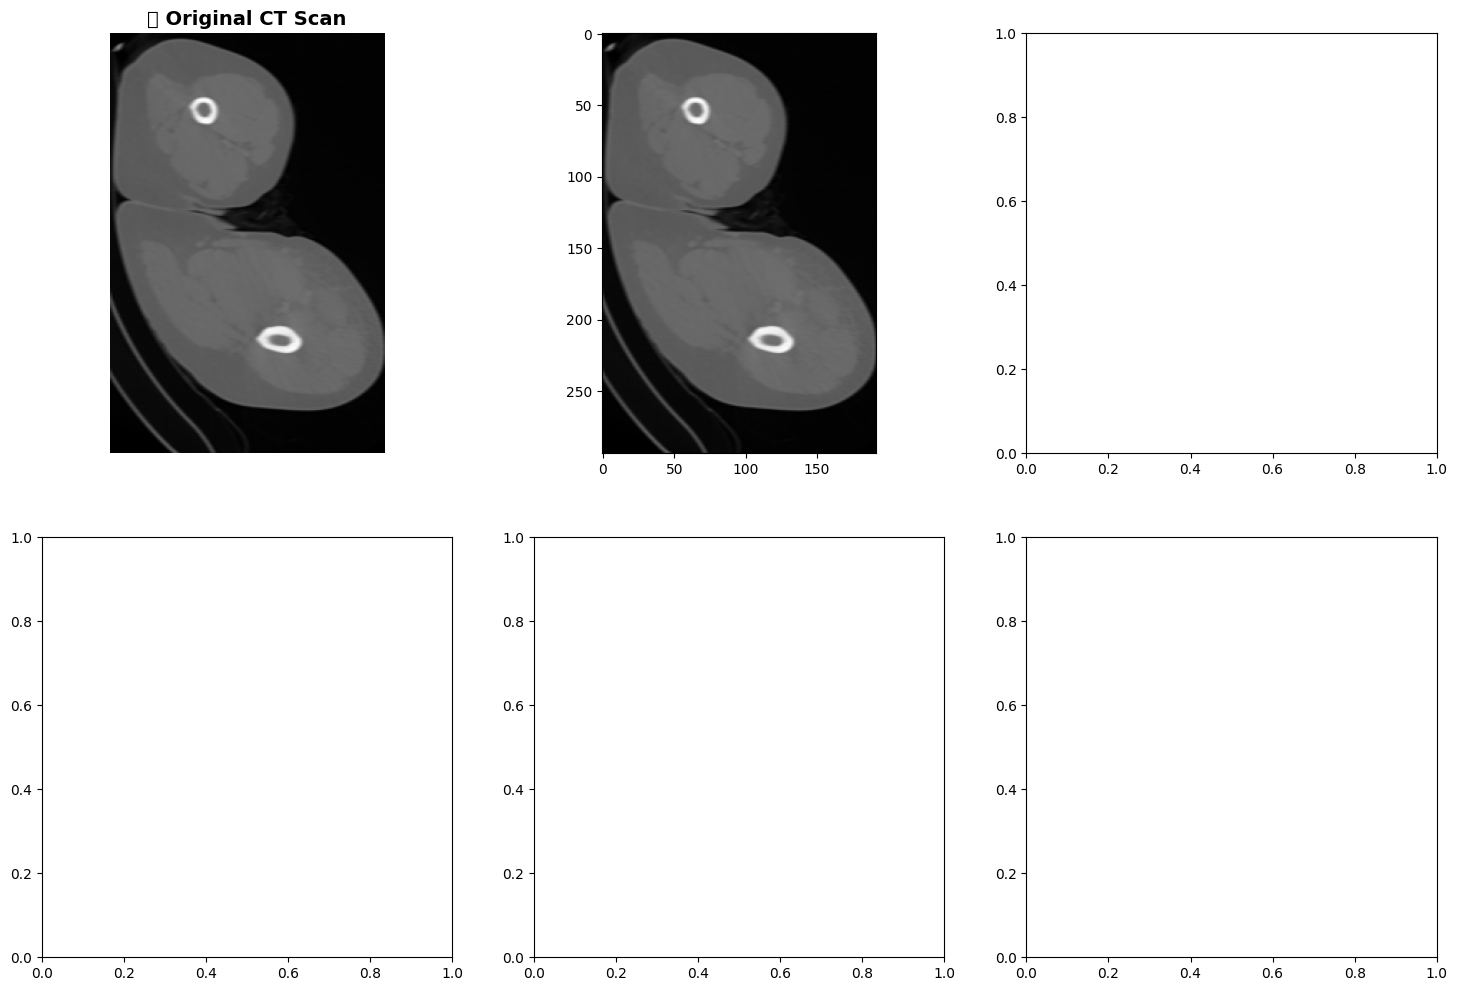

In [ ]:
# Step 10: Show colorful 2D slices
def show_colorful_slices(patient_id="s0000", organs_to_show=None):
    """Show 2D slices with colorful overlays"""
    if organs_to_show is None:
        organs_to_show = list(colorful_viz.colors.keys())[:6]

    patient_path = f"/content/{patient_id}"
    ct_path = os.path.join(patient_path, "ct.nii.gz")

    if not os.path.exists(ct_path):
        print("CT scan not found!")
        return

    # Load CT
    ct_img = nib.load(ct_path)
    ct_data = ct_img.get_fdata()

    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    slice_idx = ct_data.shape[2] // 2

    # Color map for organs
    organ_colors = {
        'colon': 'green',
        'urinary_bladder': 'lime',
        'hip_right': 'orange',
        'hip_left': 'darkorange',
        'femur_left': 'red',
        'femur_right': 'coral'
    }

    # Show CT scan
    axes[0].imshow(ct_data[:, :, slice_idx], cmap='gray')
    axes[0].set_title('🖼️ Original CT Scan', fontsize=14, fontweight='bold')
    axes[0].axis('off')

    # Show each organ
    for i, organ in enumerate(organs_to_show[:5], 1):
        organ_path = os.path.join(patient_path, "segmentations", f"{organ}.nii.gz")

        if os.path.exists(organ_path):
            organ_img = nib.load(organ_path)
            organ_data = organ_img.get_fdata()

            color = organ_colors.get(organ, 'red')

            axes[i].imshow(ct_data[:, :, slice_idx], cmap='gray')
            axes[i].imshow(organ_data[:, :, slice_idx], cmap=color + 's', alpha=0.7)
            axes[i].set_title(f'🎨 {organ.replace("_", " ").title()}', fontsize=12, fontweight='bold')
            axes[i].axis('off')
        else:
            axes[i].text(0.5, 0.5, f'{organ} not found',
                        ha='center', va='center', transform=axes[i].transAxes, fontsize=12)
            axes[i].axis('off')

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.suptitle('🌈 Colorful Organ Segmentations - 2D Slices', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Show colorful slices
if organs_loaded:
    show_colorful_slices("s0000", organs_loaded)